In [1]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import pickle
from joblib import Parallel, delayed
from SALib.sample import saltelli
from IPython.display import clear_output
import numpy as np

from model import SugarscapeG1mt

### Sensitivity Analysis - Problem

In [ ]:
# problem = {
#     "num_vars": 12,
#     "names": [
#         "initial_population",
#         "endowment_min",
#         "endowment_max",
#         "vision_min",
#         "vision_max",
#         "metabolism_min",
#         "metabolism_max",
#         "wealth_tax_system",
#         "flat_rate",
#         "wealth_tax_period",
#         "income_tax_system",
#         "income_tax_flat_rate"
#     ],
#     "bounds": [
#         [50,   500],    # initial_population
#         [10,    50],    # endowment_min
#         [50,   100],    # endowment_max
#         [1,     10],    # vision_min
#         [1,     10],    # vision_max
#         [1,     10],    # metabolism_min
#         [1,     10],    # metabolism_max
#         [0,     3],     # wealth_tax_regime (see wealth_tax_map)
#         [0.0,   0.10],  # flat_rate
#         [1,     50],    # wealth_tax_period
#         [0,     3],     # income_tax_system (see income_tax_map)
#         [0.0,   0.20],  # income_tax_flat_rate
#     ]
# }
problem = {
    "num_vars": 15,
    "names": [
        "initial_population",
        "endowment_min",
        "endowment_max",
        "vision_min",
        "vision_max",
        "metabolism_min",
        "metabolism_max",
        "wealth_tax_system",
        "flat_rate",
        "wealth_tax_period",
        "income_tax_system",
        "income_tax_flat_rate",
        "p_copy",
        "p_mutate",
        "enable_staghunt"
    ],
    "bounds": [
        [50,   500],    # initial_population
        [0,    10],    # endowment_min
        [15,   30],    # endowment_max
        [1,     10],    # vision_min
        [1,     10],    # vision_max
        [1,     10],    # metabolism_min
        [1,     10],    # metabolism_max
        [0,     3],     # wealth_tax_system
        [0.0,   0.10],  # flat_rate
        [1,     50],    # wealth_tax_period
        [0,     3],     # income_tax_system
        [0.0,   0.20],  # income_tax_flat_rate
        [0.0,   1.0],   # p_copy
        [0.0,   0.20],  # p_mutate
        [0,     1]      # enable_staghunt
    ]
}

model_reporters = {
    "Gini": lambda m:m.datacollector.get_model_vars_dataframe()['Gini'].iloc[-1],
    "Avg Wealth": lambda m:m.datacollector.get_model_vars_dataframe()['Average Wealth'].iloc[-1],

}

wealth_tax_map = {
    0: "none",  # No wealth tax
    1: "proportional",  # Proportional
    2: "progressive",  # Progressive tax
    3: "degressive"   # Regressive tax
}

income_tax_map = {
    0: "none",  # No income tax
    1: "proportional",  # Proportional income tax
    2: "progressive",  # Progressive income tax
    3: "degressive"   # Regressive income tax
}

integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
    "wealth_tax_period",
    "wealth_tax_system",
    "income_tax_system",
    "enable_staghunt"
}

In [ ]:

# --- 2) OFAT (one-factor-at-a-time) sweep ---
replicates   = 2
max_steps    = 10
distinct_OAT = 2

test_vars = ["initial_population", "flat_rate"]

OAT_results = {}
# for i, var in enumerate(problem["names"]):
for var in test_vars:
    i = problem["names"].index(var)
    low, high = problem["bounds"][i]

    # 5a) Categorical parameters: use the map values
    if var == "wealth_tax_regime":
        samples = list(wealth_tax_map.values())
    elif var == "income_tax_system":
        samples = list(income_tax_map.values())

    # 5b) Integer parameters: linspace with dtype=int
    elif var in integer_vars:
        samples = np.linspace(low, high, distinct_OAT, dtype=int)

    # 5c) All other continuous parameters
    else:
        samples = np.linspace(low, high, distinct_OAT)

    # 6) Run the batch
    results = batch_run(
        SugarscapeG1mt,
        parameters={var: samples},
        iterations=replicates,
        max_steps=max_steps,
        data_collection_period=1,
        display_progress=True
    )

    # 7) Collect into a DataFrame
    df = pd.DataFrame(results)
    # print(df.columns.tolist())    # ← inspect the real column names
    # print(df.head())       
    # keep only the columns we care about:
    #   - the varied var
    #   - the run number
    #   - the final reporter ("Gini")
    OAT_results[var] = df[[var, "RunId", "Gini"]]
for var, df in OAT_results.items():
    print(f"\n=== {var} ===")
    print(df)

In [ ]:
for var in ["initial_population", "flat_rate"]:
    df = OAT_results[var]   # this DF has columns [var, "Gini"]

    # Group by the parameter value
    grp = df.groupby(var)["Gini"]
    x    = grp.mean().index.astype(float)
    y    = grp.mean().values
    sem  = grp.sem().values
    ci   = 1.96 * sem    # 95% interval

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker="o")
    plt.fill_between(x, y - ci, y + ci, alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Final Gini")
    plt.title(f"OAT: {var} → Gini\n(n={len(df)} runs)")
    plt.tight_layout()
    plt.show()

### Global Sensitivity Analysis - Sobol (Parallel)

In [4]:
measure = "Avg Wealth" # "Gini" # or "Avg Wealth"
second_order = True  # or: "True"

# --- 3) Sobol GSA ---
replicates = 2
max_steps = 100
distinct_SA = 2

In [5]:

param_values = saltelli.sample(problem, distinct_SA, calc_second_order=second_order)
total_runs = replicates * len(param_values)
print(f"Total runs for Sobol GSA: {total_runs}")

# --- Helper function to run a single model execution ---
def run_single_sim(run_id, vals):
    vals = list(vals)
    params = {}
    for name, val in zip(problem["names"], vals):
        if name in integer_vars:
            params[name] = int(round(val))
        elif name == "wealth_tax_system":
            params[name] = wealth_tax_map[int(round(val))]
        elif name == "income_tax_system":
            params[name] = income_tax_map[int(round(val))]
        else:
            params[name] = float(val)

    for low_key, high_key in [
        ("endowment_min", "endowment_max"),
        ("vision_min", "vision_max"),
        ("metabolism_min", "metabolism_max"),
    ]:
        lo = params[low_key]
        hi = params[high_key]
        lo, hi = int(min(lo, hi)), int(max(lo, hi))
        params[low_key], params[high_key] = lo, hi

    params["enable_staghunt"] = bool(params["enable_staghunt"])
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=1,
        display_progress=False
    )[0]

    return {
        **params,
        "RunId": run_id,
        "Gini": out["Gini"],
        "Avg Wealth": out["Average Wealth"] }

# --- Create tasks ---
tasks = [(run_id, vals) for run_id in range(replicates) for vals in param_values]

# --- Run in parallel ---
results = Parallel(n_jobs=-1, verbose=10)(delayed(run_single_sim)(run_id, vals) for run_id, vals in tasks)

# --- Done ---
records = results
print(f"Completed all {total_runs} runs.")

# --- 5) Save results ---
output_path = "sobol_gsa_results.pkl"
with open(output_path, "wb") as f:
    pickle.dump(results, f)

print(f"\n All {total_runs} runs completed and saved to '{output_path}'.")


Total runs for Sobol GSA: 128


/var/folders/xz/r4qpf3bd2m3fdd46txvk5j0h0000gn/T/ipykernel_97375/1342312089.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_SA, calc_second_order=second_order)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   51.7s
/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.wa

Completed all 128 runs.

 All 128 runs completed and saved to 'sobol_gsa_results.pkl'.


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  2.9min finished


/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


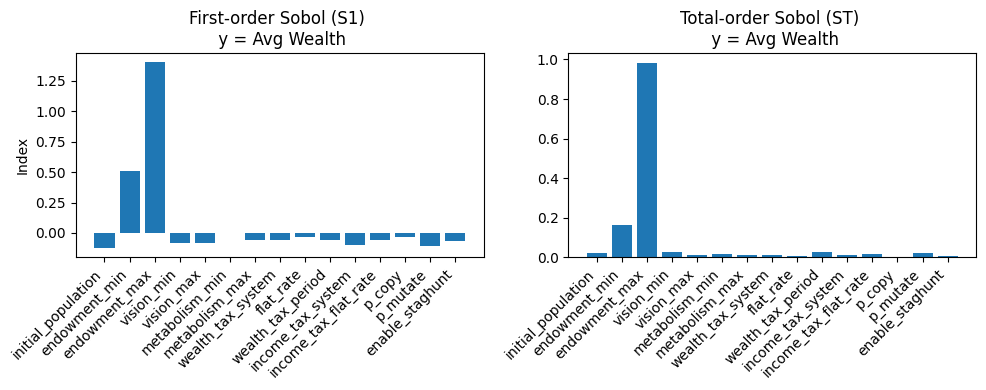

In [6]:
# 7) Build the DataFrame and extract Y
with open("sobol_gsa_results.pkl", "rb") as f:
    records = pickle.load(f)
df = pd.DataFrame(records)
Y  = df[str(measure)].values

# 8) Perform Sobol analysis
Si = sobol.analyze(
    problem,
    Y,
    calc_second_order=second_order,
    print_to_console=False
)

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# First‐order
axes[0].bar(problem["names"], Si["S1"])
axes[0].set_title(f"First‐order Sobol (S1) \n y = {measure}")
axes[0].set_ylabel("Index")
# rotate labels
axes[0].tick_params(axis="x", labelrotation=45)
# right‐align tick labels
for lbl in axes[0].get_xticklabels():
    lbl.set_ha("right")

# Total‐order
axes[1].bar(problem["names"], Si["ST"])
axes[1].set_title(f"Total‐order Sobol (ST) \n y = {measure}")
axes[1].tick_params(axis="x", labelrotation=45)
for lbl in axes[1].get_xticklabels():
    lbl.set_ha("right")

plt.show()